# What to do before running this notebook

In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# define these
# 1. location of libs 
# 2. location of results
# 3. station to lock at for the later plots (4 = LA N. Main St.)
# 4. sensor names
# 5. number of future frames being predicted
sys.path.append("/home/mgraca/Workspace/hrrr-smoke-viz")
cwd = '/home/mgraca/Workspace/hrrr-smoke-viz/pwwb-experiments/tensorflow/experiment_output/channel_investigation_20250709_173826'
station = 4
sensor_names = [
    'Simi Valley - Cochran Street', 'Reseda', 'Santa Clarita', 'North Holywood', 
    'Los Angeles - N. Main Street', 'Compton', 'Long Beach Signal Hill', 'Anaheim', 'Glendora - Laurel', 
    #'Mira Loma - Van Buren', 'Riverside - Rubidoux', 'Lake Elsinore - W. Flint Street', 
    #'Crestline - Lake Gregory', 'Temecula (Lake Skinner)', 'Fontana - Arrow Highway', 'EBAM-2'
]
frames = 1

# Data Parameters
Input

- Frames: 5 in 5 out
- Target: 1 station (LA N. Main St.)
- Channels: AirNow, Wind U/V

Model
- Variation
```
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 40, 40, 15)  │         9,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 40, 40, 30)  │        48,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 40, 40, 15)  │        12,165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 40, 40, 1)   │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │        40,005 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 5, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
```
- Adam 1e-4 LR, 1e-2 WD

Result
- ?

General Notes
- Trying out 5 frame out prediction with extra dense layer to allow communication between frames

# Model stats

In [3]:
from libs.plotting import *

# get paths with results folder
results = []
for dirpath, _, filenames in os.walk(cwd):
    if 'metadata.json' in filenames:
        filepath = os.path.join(dirpath, 'metadata.json')
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                data = pd.read_json(f)
                data = data.drop(columns=['channel_names', 'timestamp', 'batch_size', 'training_time_seconds'])
                data = data.drop_duplicates()
                results.append(data)
        except Exception as e:
            print(f"Error reading {filepath}: {e}")

df = pd.concat(results, ignore_index=True)
relevant_cols = ['experiment_id', 'final_validation_loss', 'RMSE', 'NRMSE', 'MAE', 'R2']

#pd.set_option('display.max_rows', None)
pd.set_option('display.width', 135)
pd.set_option('display.max_columns', 6)

# print results
print("Full")
display(df[relevant_cols])
print()

print("By valid loss")
display(df[relevant_cols].sort_values(by='final_validation_loss')[:10])
print()

print("By nrmse (on test set)")
display(df[relevant_cols].sort_values(by='NRMSE')[:10])
best_model_path = os.path.join(cwd, df.sort_values(by='NRMSE')['experiment_id'][0], 'results') 
print(best_model_path)

# which channels give the best nrmse with their inclusion in the model?
value_names = [
    'final_validation_loss',
    'RMSE', 
    'NRMSE', 
    'R2', 
    'MAE'
]
channel_names = [
    'MAIAC_AOD', 'METAR_Wind_U', 'METAR_Wind_V', 'HRRR_COLMD', 'TROPOMI_NO2'    
]

dfs = []
for c in channel_names:
    temp_df = df[df[c] == 1.0].mean(numeric_only=True).to_frame().T[value_names]
    temp_df.index = [c]
    dfs.append(temp_df)

airnow_df = df.loc[2].to_frame().T
airnow_df.index = ['AirNow only']
channel_perf_df = pd.concat([*dfs, airnow_df], join='inner', axis=0)

print("Models with this channel included, by nrmse (on test set)")
display(channel_perf_df.sort_values(by='NRMSE'))

Full


,experiment_id,final_validation_loss,RMSE,NRMSE,MAE,R2
0,airnow_aod_wind_hrrr_classic,13.383800,10.161922,122.266139,6.691875,-0.520528
1,airnow_no2_wind_hrrr_classic,13.400377,10.163509,122.285239,6.575376,-0.521003
2,airnow_wind_classic,13.559187,10.052308,120.947291,6.320987,-0.487902
3,airnow_no2_aod_hrrr_classic,12.567773,9.644788,116.044096,6.173400,-0.369708
4,airnow_aod_wind_classic,13.121133,10.342211,124.435343,6.980697,-0.574960
5,airnow_no2_wind_classic,14.023372,10.365772,124.718823,6.768937,-0.582144
6,airnow_no2_aod_wind_classic,11.256752,8.767929,105.493906,4.673901,-0.131975
7,airnow_aod_classic,14.175673,10.533411,126.735827,6.957997,-0.633732
8,airnow_no2_aod_classic,13.097654,9.968528,119.939262,6.526106,-0.463203
9,airnow_only_classic,12.514227,9.549883,114.902217,5.855017,-0.342885



By valid loss


,experiment_id,final_validation_loss,RMSE,NRMSE,MAE,R2
6,airnow_no2_aod_wind_classic,11.256752,8.767929,105.493906,4.673901,-0.131975
13,airnow_no2_hrrr_classic,11.773000,8.898844,107.069045,5.400074,-0.166030
11,airnow_wind_hrrr_classic,12.385228,9.689710,116.584588,6.351877,-0.382497
9,airnow_only_classic,12.514227,9.549883,114.902217,5.855017,-0.342885
3,airnow_no2_aod_hrrr_classic,12.567773,9.644788,116.044096,6.173400,-0.369708
14,airnow_no2_classic,12.670095,9.487441,114.150924,5.737322,-0.325381
8,airnow_no2_aod_classic,13.097654,9.968528,119.939262,6.526106,-0.463203
4,airnow_aod_wind_classic,13.121133,10.342211,124.435343,6.980697,-0.574960
15,airnow_all_channels_classic,13.139882,10.212611,122.876017,6.714178,-0.535735
0,airnow_aod_wind_hrrr_classic,13.383800,10.161922,122.266139,6.691875,-0.520528



By nrmse (on test set)


,experiment_id,final_validation_loss,RMSE,NRMSE,MAE,R2
6,airnow_no2_aod_wind_classic,11.256752,8.767929,105.493906,4.673901,-0.131975
13,airnow_no2_hrrr_classic,11.773000,8.898844,107.069045,5.400074,-0.166030
14,airnow_no2_classic,12.670095,9.487441,114.150924,5.737322,-0.325381
9,airnow_only_classic,12.514227,9.549883,114.902217,5.855017,-0.342885
3,airnow_no2_aod_hrrr_classic,12.567773,9.644788,116.044096,6.173400,-0.369708
11,airnow_wind_hrrr_classic,12.385228,9.689710,116.584588,6.351877,-0.382497
8,airnow_no2_aod_classic,13.097654,9.968528,119.939262,6.526106,-0.463203
2,airnow_wind_classic,13.559187,10.052308,120.947291,6.320987,-0.487902
0,airnow_aod_wind_hrrr_classic,13.383800,10.161922,122.266139,6.691875,-0.520528
1,airnow_no2_wind_hrrr_classic,13.400377,10.163509,122.285239,6.575376,-0.521003


/home/mgraca/Workspace/hrrr-smoke-viz/pwwb-experiments/tensorflow/experiment_output/channel_investigation_20250709_173826/airnow_aod_wind_hrrr_classic/results
Models with this channel included, by nrmse (on test set)


,final_validation_loss,RMSE,NRMSE,R2,MAE
TROPOMI_NO2,12.741113,9.688678,116.572164,-0.386897,6.071162
METAR_Wind_U,13.033716,9.969496,119.950918,-0.467093,6.384729
METAR_Wind_V,13.033716,9.969496,119.950918,-0.467093,6.384729
HRRR_COLMD,13.090862,9.978266,120.056432,-0.469927,6.491868
MAIAC_AOD,13.108162,10.030125,120.680393,-0.485912,6.483837
AirNow only,13.559187,10.052308,120.947291,-0.487902,6.320987


# Model Evaluation

In [4]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

# Evaluate model
model = keras.saving.load_model(os.path.join(best_model_path, 'model.keras'))
model.summary()

2025-07-09 17:49:48.094703: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-09 17:49:48.102848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752108588.113351   42655 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752108588.116808   42655 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-09 17:49:48.127117: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 40, 40, 15)  │        10,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 40, 40, 30)  │        48,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 40, 40, 15)  │        12,165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 40, 40, 1)   │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │        72,009 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 9)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 432,482 (1.65 MB)

 Trainable params: 144,160 (563.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 288,322 (1.10 MB)

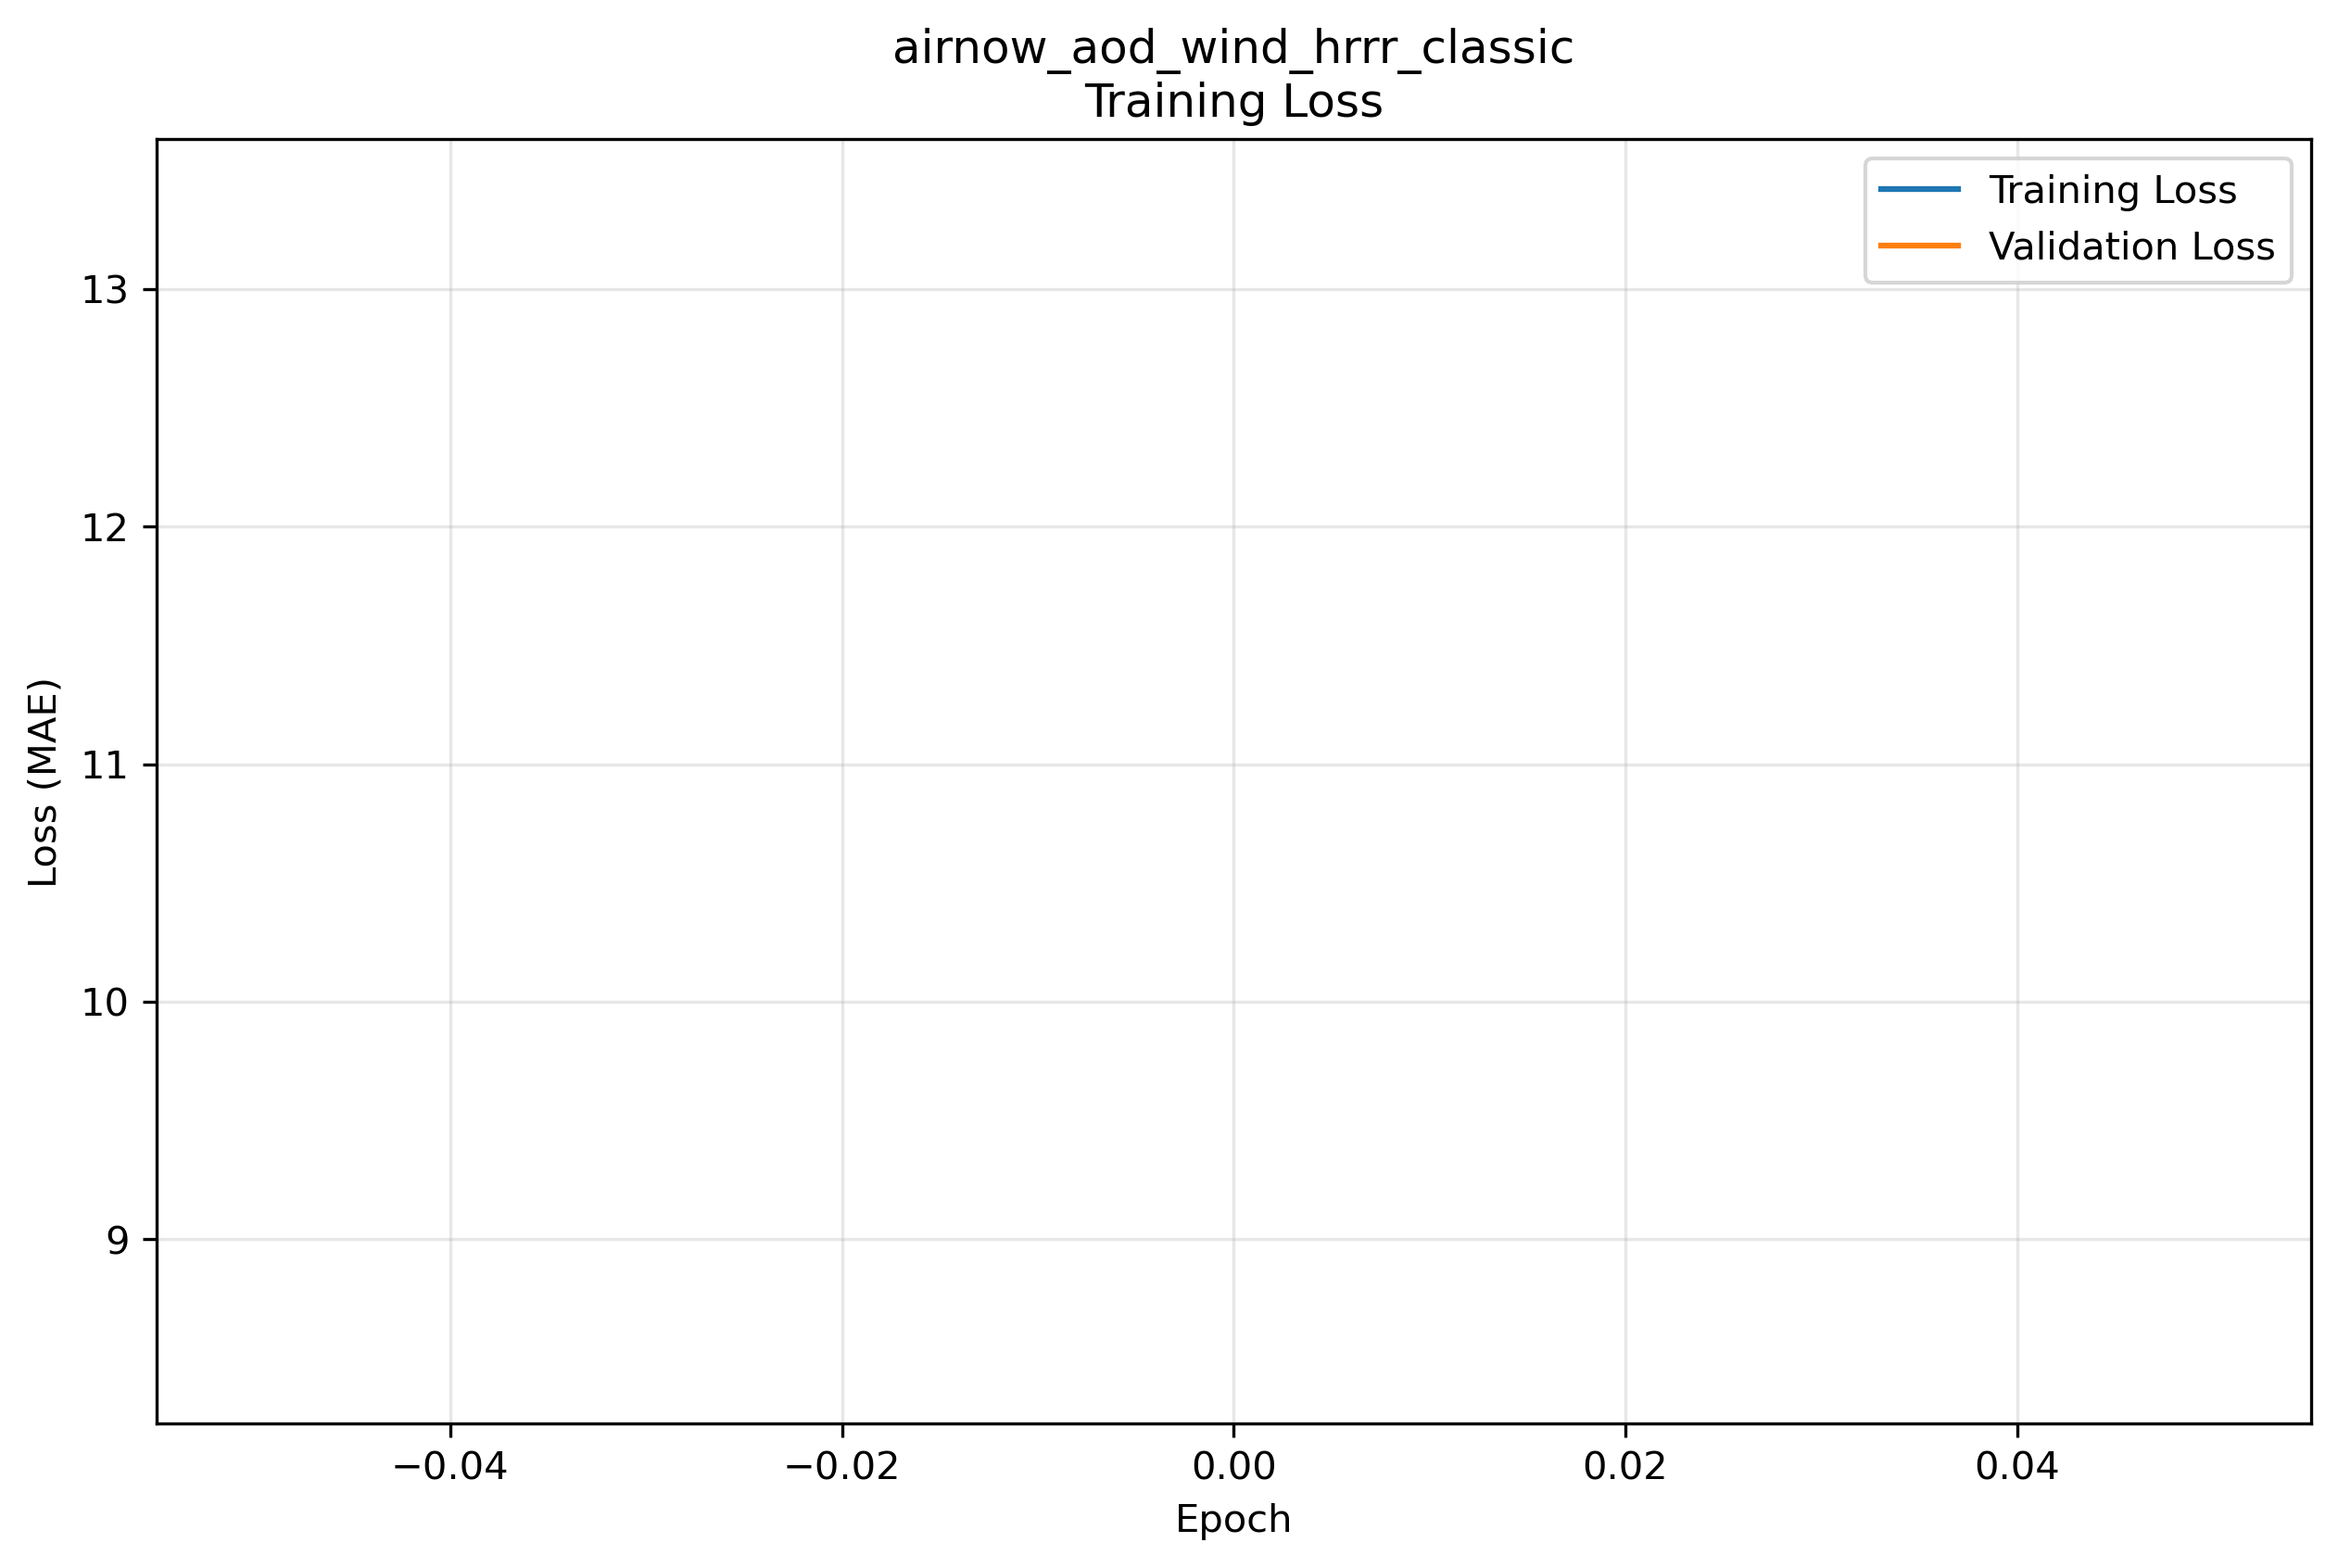

In [5]:
from PIL import Image

image = Image.open(os.path.join(best_model_path, 'training_curves.png'))
display(image)

In [6]:
Y_test = np.load(os.path.join(best_model_path, 'Y_test.npy'))
y_pred = np.load(os.path.join(best_model_path, 'y_pred.npy'))

print(Y_test.shape, y_pred.shape)
results = [
    [
        rmse(Y_test[1:], Y_test[:-1]), 
        rmse(y_pred, Y_test),
        rmse(y_pred[1:], Y_test[:-1]),
    ],
    [
        nrmse(Y_test[1:], Y_test[:-1]),
        nrmse(y_pred, Y_test),        
        nrmse(y_pred[1:], Y_test[:-1]),

    ],
    [        
        mae(Y_test[1:], Y_test[:-1]),
        mae(y_pred, Y_test),
        mae(y_pred[1:], Y_test[:-1]),
    ],
    [
        r2_score(Y_test[:-1].flatten(), Y_test[1:].flatten()),
        r2_score(Y_test.flatten(), y_pred.flatten()),
        r2_score(Y_test[:-1].flatten(), y_pred[1:].flatten()),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'R2']
)
display(df)

(110, 1, 9) (110, 1, 9)


,Baseline Error,Model Error,Model Error Shifted
RMSE,5.506114,10.161922,10.202390
NRMSE,65.965238,122.266139,122.228330
MAE,1.794292,6.691875,6.733071
R2,0.556201,-0.520528,-0.523702


In [7]:
# first-frame error
results = [
    [
        rmse(Y_test[1:, 0], Y_test[:-1, 0]), 
        rmse(y_pred[:, 0], Y_test[:, 0]),
        rmse(y_pred[1:, 0], Y_test[:-1, 0]),
    ],
    [
        nrmse(Y_test[1:, 0], Y_test[:-1, 0]),
        nrmse(y_pred[:, 0], Y_test[:, 0]),        
        nrmse(y_pred[1:, 0], Y_test[:-1, 0]),

    ],
    [        
        mae(Y_test[1:, 0], Y_test[:-1, 0]),
        mae(y_pred[:, 0], Y_test[:, 0]),
        mae(y_pred[1:, 0], Y_test[:-1, 0]),
    ],
    [
        r2_score(Y_test[:-1, 0], Y_test[1:, 0]),
        r2_score(Y_test[:, 0], y_pred[:, 0]),
        r2_score(Y_test[:-1, 0], y_pred[1:, 0]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,5.506114,10.161922,10.202390
NRMSE,65.965238,122.266139,122.228330
MAE,1.794292,6.691875,6.733071
R2,0.762151,-1.633110,-1.656189


📊 TEMPORAL DEGRADATION ANALYSIS
This measures how ConvLSTM prediction accuracy degrades as we predict further into the future.
Later time steps are inherently harder to predict due to error accumulation.



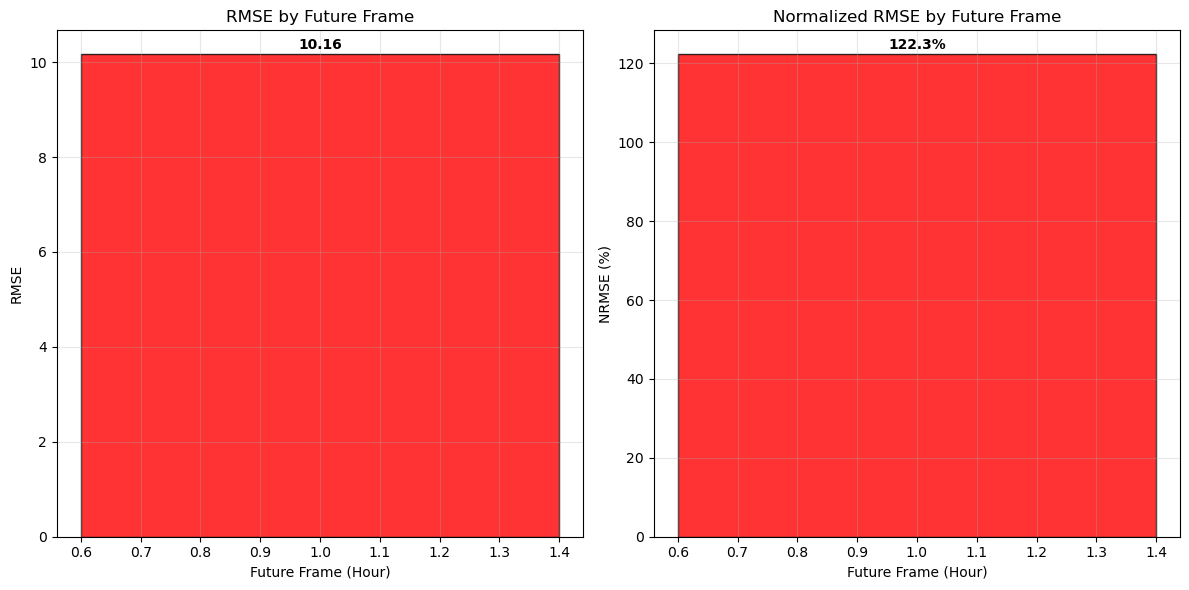


📊 FRAME-BY-FRAME RMSE SUMMARY:
Hour 1: RMSE = 10.162 (122.3%)
📋 DETAILED CONVLSTM PERFORMANCE BREAKDOWN
This section provides comprehensive metrics for each prediction horizon and monitoring station.
Essential for identifying specific model weaknesses and guiding improvements.

📋 DETAILED FRAME-BY-FRAME STATISTICS

🕐 HOUR 1 ANALYSIS
────────────────────────────────────────────────────────────────────────────────────────────────────
┌─ OVERALL PERFORMANCE ──────────────────────────────────────────────────────────┐
│ RMSE: 10.162 (122.3%)   │   MAE:  6.692   │   R²: -0.521              │
└────────────────────────────────────────────────────────────────────────────────┘

📍 BY SENSOR LOCATION:
────────────────────────────────────────────────────────────────────────────────────────────────────
Location                 │RMSE   │%     │MAE    │R²     │Actual │Pred  
─────────────────────────┼───────┼──────┼───────┼───────┼───────┼──────
Simi Valley - Cochran St │5.58   │85.5  %│4.90   │-2.09

In [8]:
plot_frame_by_frame_rmse(y_pred, Y_test)
print_detailed_frame_stats(y_pred, Y_test, sensor_names)

# Plots
Done with only one station in mind

## Snapshot plots - first frame

In [9]:
best_week = float('inf')
worst_week = float('-inf')
best_idx, worst_idx = 0, 0

for i in range(len(y_pred) - 7):
    err = nrmse(y_pred[i:i+7, 0, station], Y_test[i:i+7, 0, station])
    if err < best_week:
        best_week = err
        best_idx = i
    if err > worst_week:
        worst_week = err
        worst_idx = i

print(f"Best week {best_idx} to {best_idx+7} at {best_week:.2f}%")
print(f"Worst week {worst_idx} to {worst_idx+7} at {worst_week:.2f}%")

Best week 31 to 38 at 42.95%
Worst week 8 to 15 at 88.67%


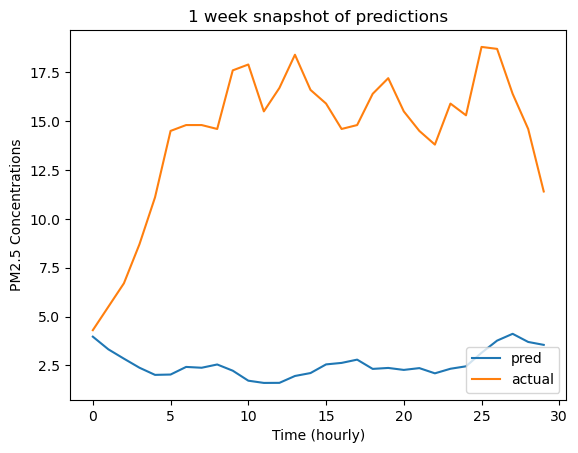

In [10]:
plt.plot(y_pred[0:30, 0, station], label='pred')
plt.plot(Y_test[0:30, 0, station], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("1 week snapshot of predictions")
plt.legend(loc="lower right")

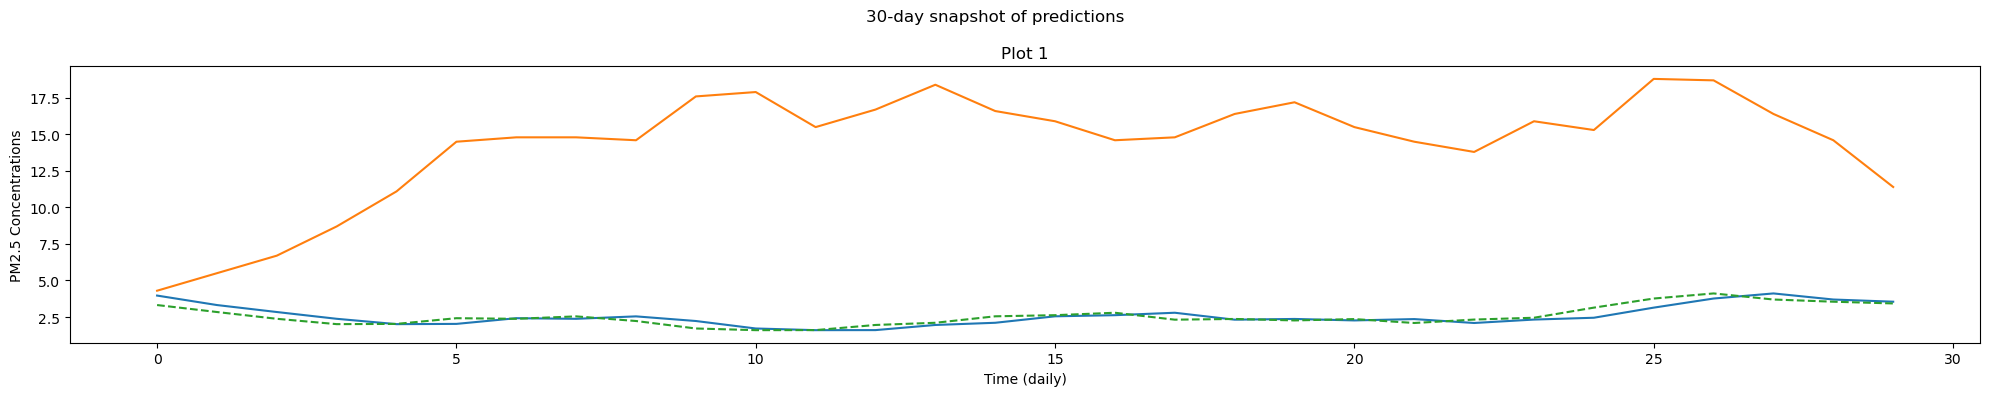

In [11]:
# plot 24 hours of data for each prediction
fig, axes = plt.subplots(1, frames, figsize=(20, 4))  # 1 row, 5 columns
fig.suptitle('30-day snapshot of predictions')

# not sure if the logic here is right?
for i in range(frames):
    if frames == 1:
        axes.plot(y_pred[:30, i, station], label='pred')
        axes.plot(Y_test[:30, i, station], label='actual')
        axes.plot(y_pred[1:31, i, station], linestyle='--', label='pred offset')
        axes.set_title(f'Plot {i+1}')
        axes.set_xlabel('Time (daily)')
        axes.set_ylabel('PM2.5 Concentrations')
    else:
        axes[i].plot(y_pred[:30, i, station], label='pred')
        axes[i].plot(Y_test[:30, i, station], label='actual')
        axes[i].plot(y_pred[1:31, i, station], linestyle='--', label='pred offset')
        axes[i].set_title(f'Plot {i+1}')
        axes[i].set_xlabel('Time (daily)')
        axes[i].set_ylabel('PM2.5 Concentrations')

# Tidy up the layout
plt.tight_layout()
plt.show()

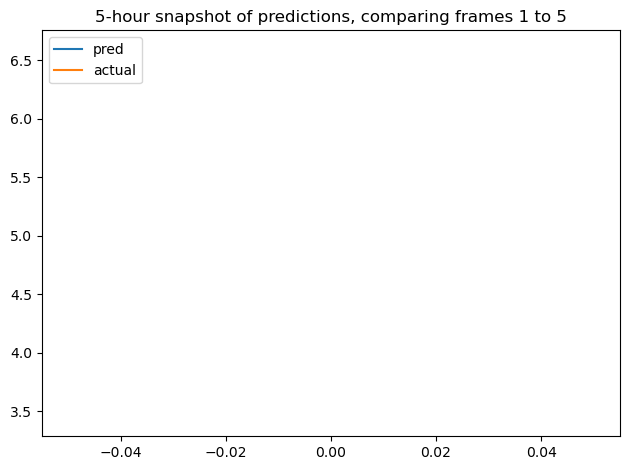

In [12]:
# compare past 5 with next 5
plt.plot(y_pred[best_idx, :, station], label='pred')
plt.plot(Y_test[best_idx, :, station], label='actual')
plt.title("5-hour snapshot of predictions, comparing frames 1 to 5")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

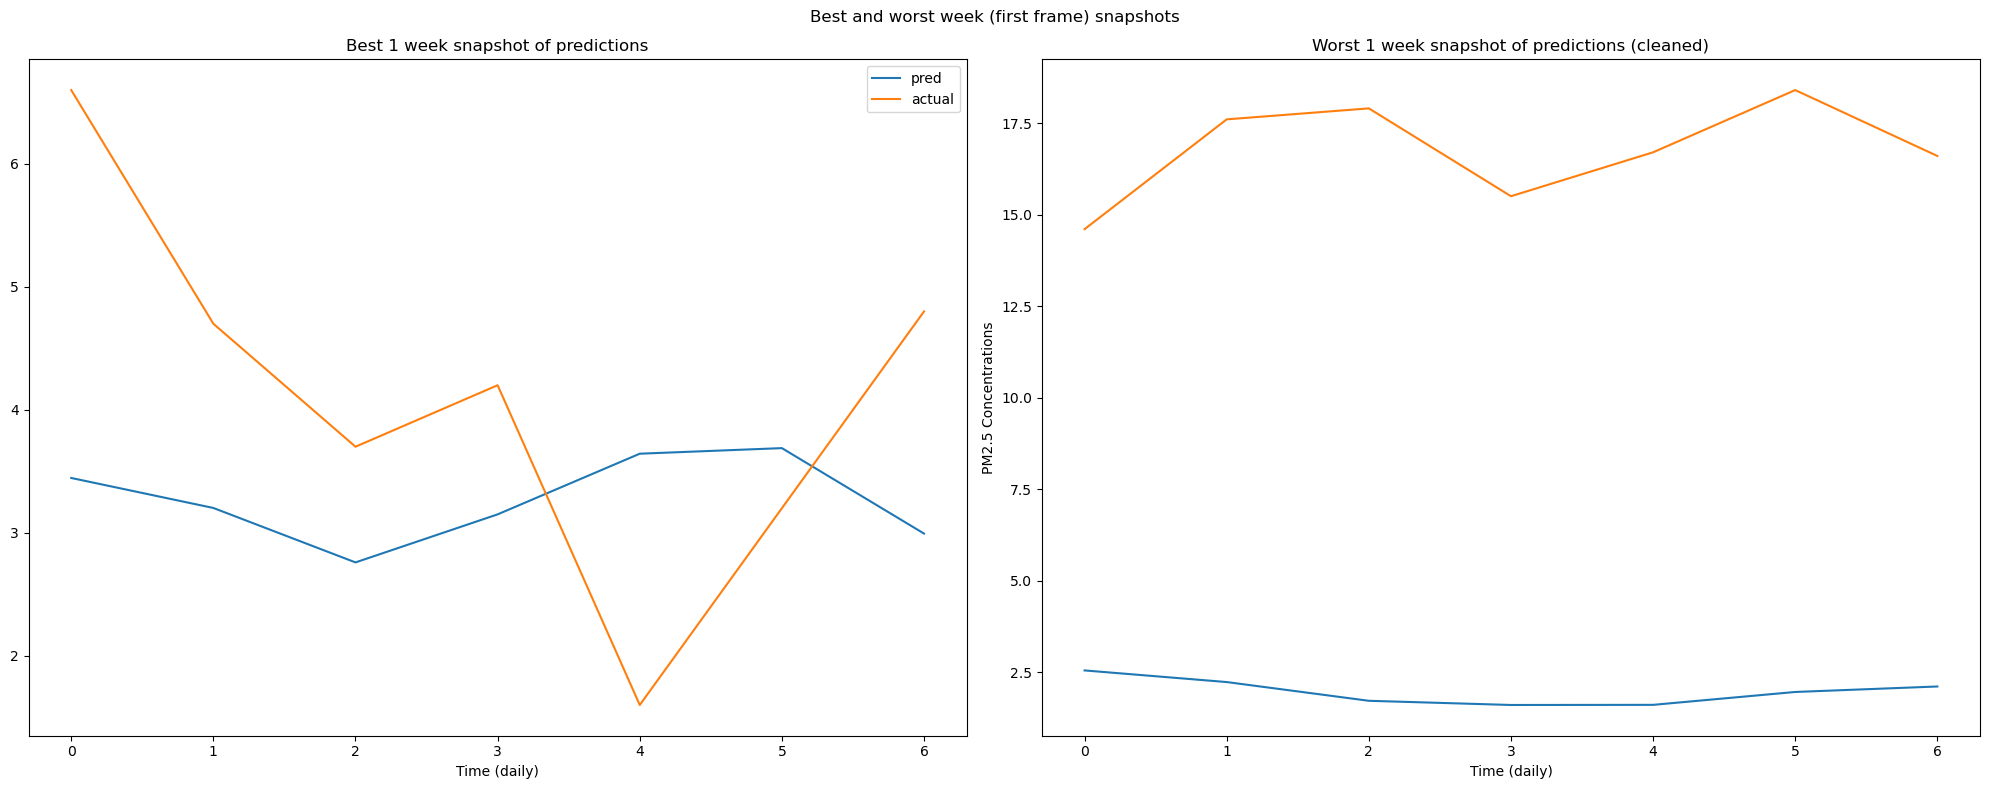

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Best and worst week (first frame) snapshots')

# best week
axes[0].plot(y_pred[best_idx:best_idx+7, 0, station], label='pred')
axes[0].plot(Y_test[best_idx:best_idx+7, 0, station], label='actual')
axes[0].set_xlabel("Time (daily)")
axes[0].set_label("PM2.5 Concentrations")
axes[0].set_title("Best 1 week snapshot of predictions")
axes[0].legend(loc="upper right")

# worst week
axes[1].plot(y_pred[worst_idx:worst_idx+7, 0, station], label='pred')
axes[1].plot(Y_test[worst_idx:worst_idx+7, 0, station], label='actual')
axes[1].set_xlabel("Time (daily)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].set_title("Worst 1 week snapshot of predictions (cleaned)")

plt.tight_layout()
plt.show()

## Rolling avg plots

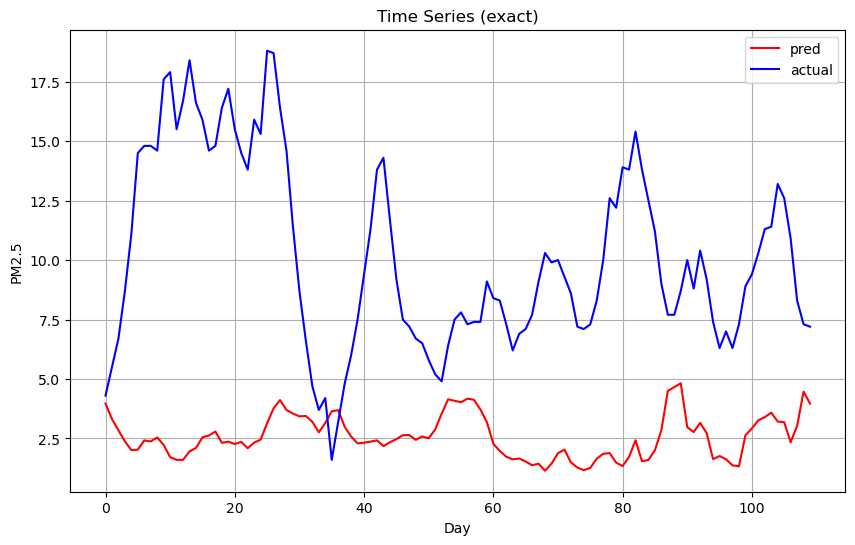

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(y_pred[:, 0, station], label=f'pred', color='red')
plt.plot(Y_test[:, 0, station], label=f'actual', color='blue')
plt.title('Time Series (exact)')
plt.xlabel('Day')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

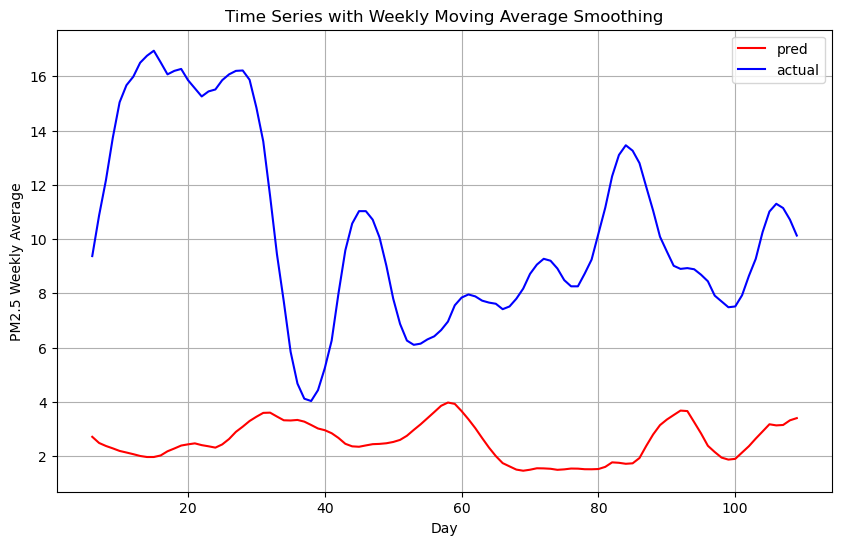

In [15]:
import pandas as pd

series_pred = pd.Series(np.squeeze(y_pred[:, 0, station]))
series_test = pd.Series(np.squeeze(Y_test[:, 0, station]))

window_size = 7 # weekly average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with Weekly Moving Average Smoothing')
plt.xlabel('Day')
plt.ylabel('PM2.5 Weekly Average')
plt.legend()
plt.grid(True)
plt.show()

## Error plots (first frame)

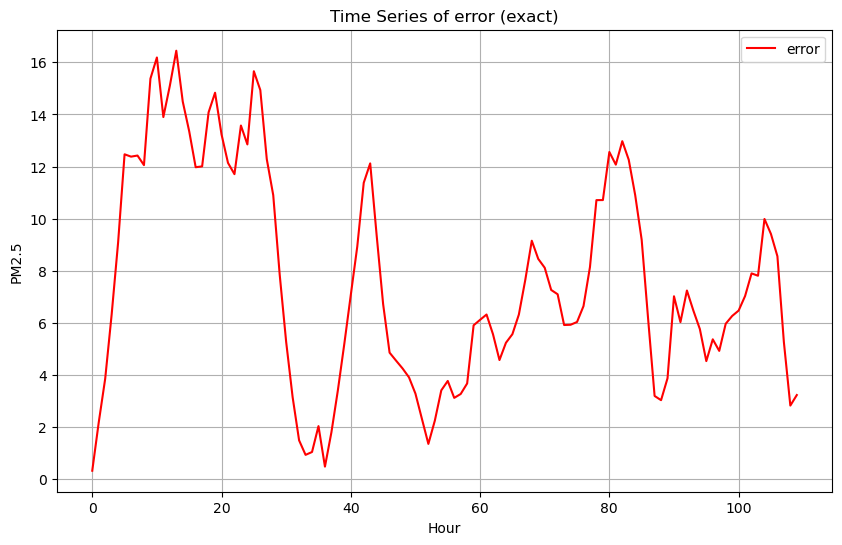

In [16]:
series = pd.Series(np.squeeze(np.abs(y_pred[:, 0, station] - Y_test[:, 0, station])))
plt.figure(figsize=(10, 6))
plt.plot(series, label=f'error', color='red')
plt.title('Time Series of error (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

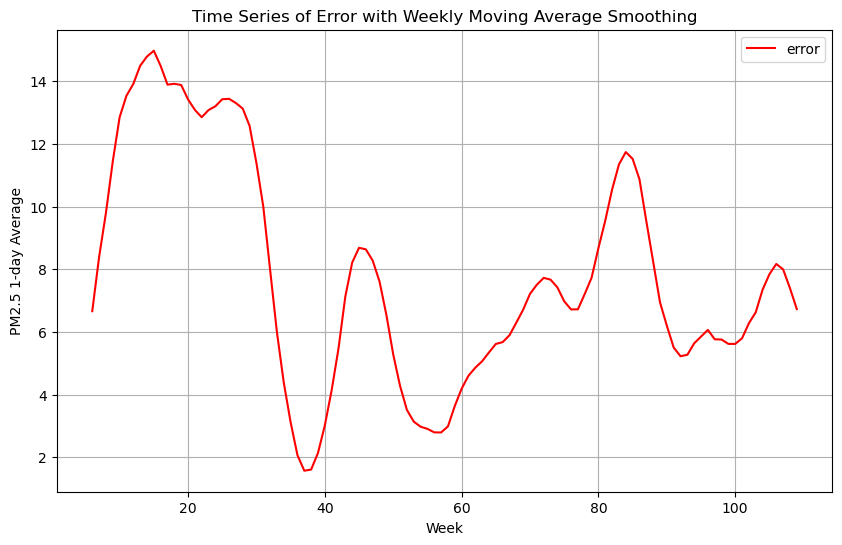

In [17]:
window_size = 7 # weekly average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with Weekly Moving Average Smoothing')
plt.xlabel('Week')
plt.ylabel('PM2.5 1-day Average')
plt.legend()
plt.grid(True)
plt.show()